# Training a Classifier  
    
## Training an image classifier

    
### 1. Loading and normalizing CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
print(torch.__version__)

1.0.0.dev20181017


In [2]:
## Transform function for throw Dataset instance
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## Train DataSet
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

## Train DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

## Test DataSet
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
## Test DataLoader
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

## Class
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0.00B [00:00, ?B/s]

100%|█████████▉| 170M/170M [02:09<00:00, 8.04MB/s]   

Files already downloaded and verified


171MB [02:20, 8.04MB/s]                           

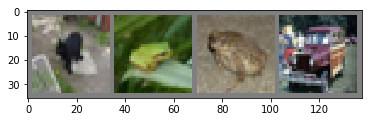

  cat  frog  frog   car


In [3]:
# functions to show an image

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. Define a Convolutional Neural Network

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Define a Loss function and optimizer

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.164
[1,  4000] loss: 1.883
[1,  6000] loss: 1.667
[1,  8000] loss: 1.575
[1, 10000] loss: 1.503
[1, 12000] loss: 1.456
[2,  2000] loss: 1.400
[2,  4000] loss: 1.351
[2,  6000] loss: 1.373
[2,  8000] loss: 1.353
[2, 10000] loss: 1.302
[2, 12000] loss: 1.309
Finished Training


### 5. Test the network on the test data

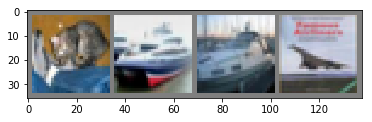

GroundTruth:    cat  ship  ship plane


In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship  ship


In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [10]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 51 %
Accuracy of   car : 73 %
Accuracy of  bird : 35 %
Accuracy of   cat : 34 %
Accuracy of  deer : 60 %
Accuracy of   dog : 47 %
Accuracy of  frog : 61 %
Accuracy of horse : 54 %
Accuracy of  ship : 83 %
Accuracy of truck : 39 %


## Training on GPU

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [12]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
inputs, labels = inputs.to(device), labels.to(device)

In [14]:
print(inputs)
print(labels)

tensor([[[[-0.3255, -0.3333, -0.3255,  ..., -0.7804, -0.7961, -0.8039],
          [-0.3020, -0.3098, -0.3020,  ..., -0.7725, -0.7882, -0.7961],
          [-0.2863, -0.2784, -0.2706,  ..., -0.7255, -0.7412, -0.7490],
          ...,
          [-0.3647, -0.3647, -0.3882,  ..., -0.7255, -0.7490, -0.7569],
          [-0.3412, -0.3490, -0.3255,  ..., -0.7255, -0.7412, -0.7647],
          [-0.3412, -0.3412, -0.3098,  ..., -0.7255, -0.7490, -0.7725]],

         [[-0.2471, -0.2549, -0.2471,  ..., -0.7725, -0.7882, -0.7961],
          [-0.2235, -0.2314, -0.2235,  ..., -0.7647, -0.7804, -0.7882],
          [-0.2078, -0.2000, -0.1922,  ..., -0.7098, -0.7333, -0.7412],
          ...,
          [-0.3647, -0.3882, -0.4275,  ..., -0.7098, -0.7333, -0.7490],
          [-0.3412, -0.3490, -0.3333,  ..., -0.7098, -0.7333, -0.7569],
          [-0.3333, -0.3333, -0.3020,  ..., -0.7176, -0.7412, -0.7647]],

         [[-0.2549, -0.2627, -0.2549,  ..., -0.8118, -0.8275, -0.8353],
          [-0.2314, -0.2392, -